In [ ]:
import os
import json
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity


TEXT_EMB_PATH = 'X_bert.npy'
TEXT_LIST_PATH = 'random_news_500.txt'

IMG_EMB_PATH = 'X_img_dino_vitb8.npy'
IMG_DIR      = 'added image'

TOP_K_TEXT2IMG = 5
TOP_K_IMG2TEXT = 5

OUT_TEXT2IMG = 'matches_text2img.json'
OUT_IMG2TEXT = 'matches_img2text.json'

print("Loading embeddings…")
X_text = np.load(TEXT_EMB_PATH)   # shape (N_text, D)
X_img  = np.load(IMG_EMB_PATH)    # shape (N_img, D)

print("Loading text list…")
with open(TEXT_LIST_PATH, 'r', encoding='utf-8') as f:
    texts = [line.strip() for line in f if line.strip()]

print("Scanning image directory…")
image_names = sorted([
    fn for fn in os.listdir(IMG_DIR)
    if fn.lower().endswith(('.jpg','.png','.jpeg','bmp'))
])
print(f"  found {len(texts)} texts, {len(image_names)} images")



print("Computing cosine similarity matrix…")
sim_matrix = cosine_similarity(X_text, X_img)  # shape (N_text, N_img)



print(f"Building top‑{TOP_K_TEXT2IMG} text→image mapping…")
text2img = {}
for i, sims in enumerate(sim_matrix):

    top_idxs = np.argsort(sims)[-TOP_K_TEXT2IMG:][::-1]
    text2img[texts[i]] = [
        (image_names[j], float(sims[j])) for j in top_idxs
    ]



print(f"Building top‑{TOP_K_IMG2TEXT} image→text mapping…")
sim_T = sim_matrix.T
img2text = {}
for j, sims in enumerate(sim_T):
    top_idxs = np.argsort(sims)[-TOP_K_IMG2TEXT:][::-1]
    img2text[image_names[j]] = [
        (texts[i], float(sims[i])) for i in top_idxs
    ]



print("Saving JSON outputs…")
with open(OUT_TEXT2IMG, 'w', encoding='utf-8') as f:
    json.dump(text2img, f, ensure_ascii=False, indent=2)

with open(OUT_IMG2TEXT, 'w', encoding='utf-8') as f:
    json.dump(img2text, f, ensure_ascii=False, indent=2)

print("Done!")
print(f" → {OUT_TEXT2IMG}")
print(f" → {OUT_IMG2TEXT}")


Loading embeddings…
Loading text list…
Scanning image directory…
  found 500 texts, 908 images
Computing cosine similarity matrix…
Building top‑5 text→image mapping…
Building top‑5 image→text mapping…
Saving JSON outputs…
Done!
 → matches_text2img.json
 → matches_img2text.json


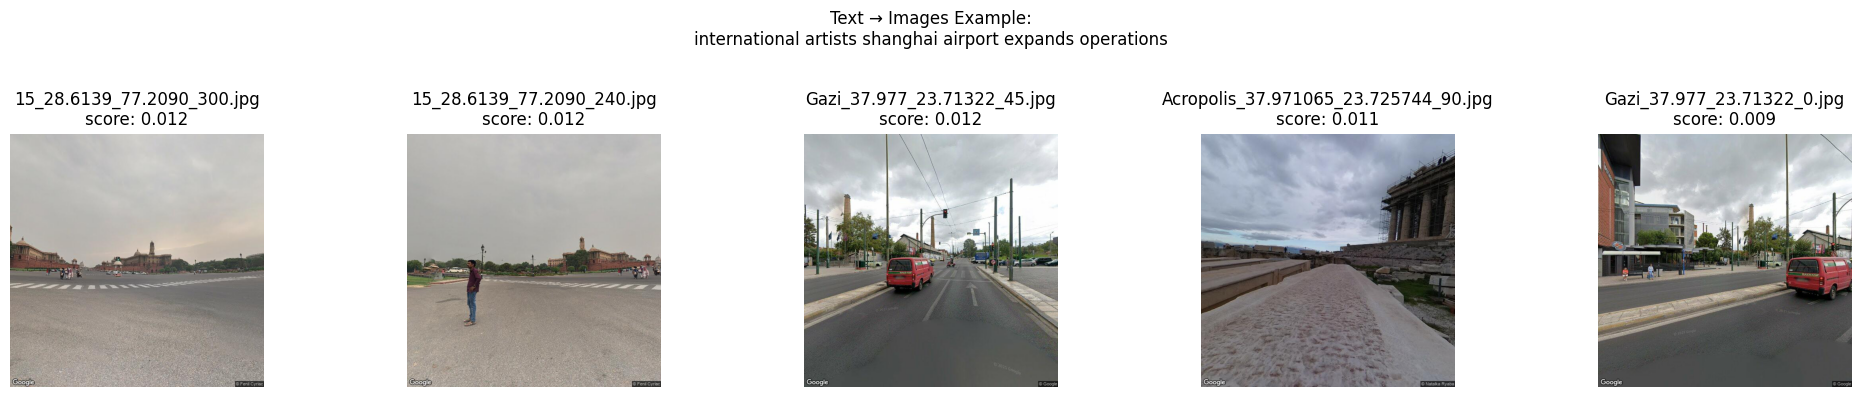

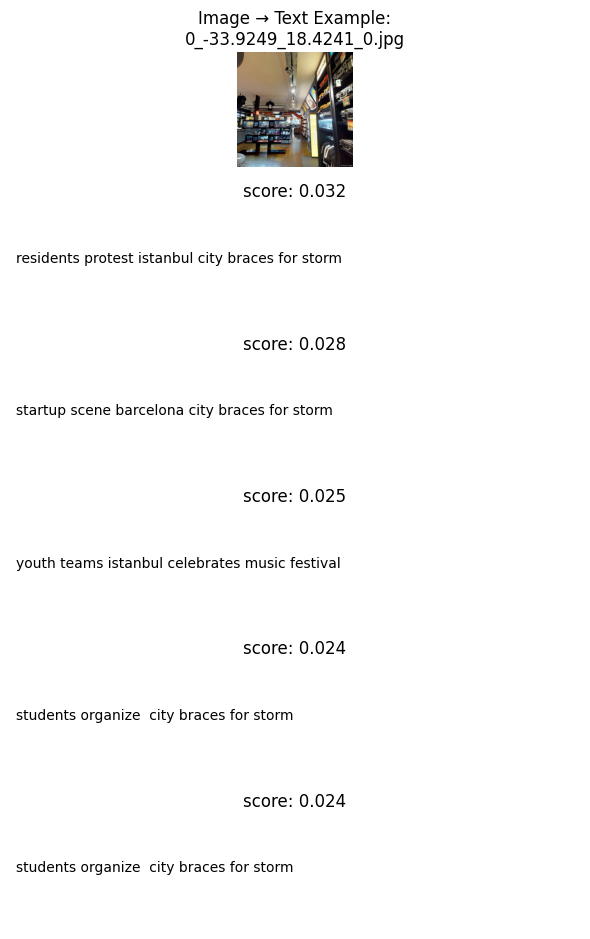

In [ ]:
import json
import os
import matplotlib.pyplot as plt
from PIL import Image

# Paths (adjust if needed)
TEXT2IMG_PATH = r"C:\Users\golds\Desktop\Vectorial Encodings\matches_text2img.json"
IMG2TEXT_PATH = r"C:\Users\golds\Desktop\Vectorial Encodings\matches_img2text.json"
IMAGE_DIR = r"C:\Users\golds\Desktop\Vectorial Encodings\added image"  # images directory

# Load mappings
with open(TEXT2IMG_PATH, 'r', encoding='utf-8') as f:
    text2img = json.load(f)
with open(IMG2TEXT_PATH, 'r', encoding='utf-8') as f:
    img2text = json.load(f)

# Example 1: Text → Images
text_example = next(iter(text2img))
matches = text2img[text_example]
fig, axes = plt.subplots(1, len(matches), figsize=(4 * len(matches), 4))
fig.suptitle(f"Text → Images Example:\n{text_example}", fontsize=12)
if len(matches) == 1:
    axes = [axes]
for ax, (img_name, score) in zip(axes, matches):
    img_path = os.path.join(IMAGE_DIR, img_name)
    try:
        img = Image.open(img_path)
        ax.imshow(img)
    except:
        ax.text(0.5, 0.5, f"Missing: {img_name}", ha='center')
    ax.set_title(f"{img_name}\nscore: {score:.3f}")
    ax.axis('off')
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

# Example 2: Image → Text
img_example = next(iter(img2text))
matches = img2text[img_example]
fig = plt.figure(figsize=(6, 2 + 1.5 * len(matches)))
# Show the image
ax_img = fig.add_subplot(len(matches)+1, 1, 1)
img_path = os.path.join(IMAGE_DIR, img_example)
try:
    img = Image.open(img_path)
    ax_img.imshow(img)
except:
    ax_img.text(0.5, 0.5, f"Missing: {img_example}", ha='center')
ax_img.set_title(f"Image → Text Example:\n{img_example}")
ax_img.axis('off')
# Show matched texts
for i, (text, score) in enumerate(matches, start=2):
    ax = fig.add_subplot(len(matches)+1, 1, i)
    ax.text(0.01, 0.5, text, wrap=True, fontsize=10)
    ax.set_title(f"score: {score:.3f}")
    ax.axis('off')
plt.tight_layout()
plt.show()


C:\Users\golds\AppData\Local\Temp\ipykernel_10204\2957358868.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdYlGn')  # green=high score, red=low score


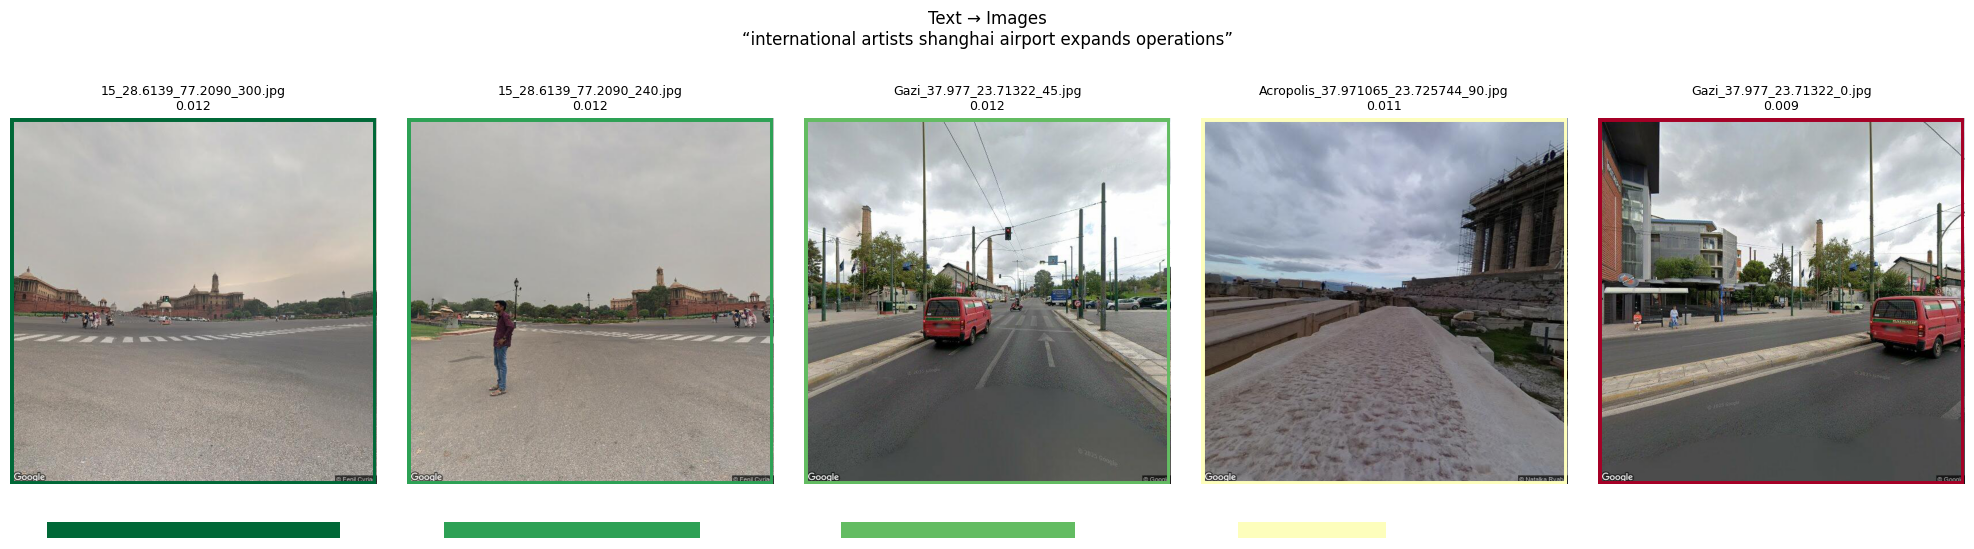

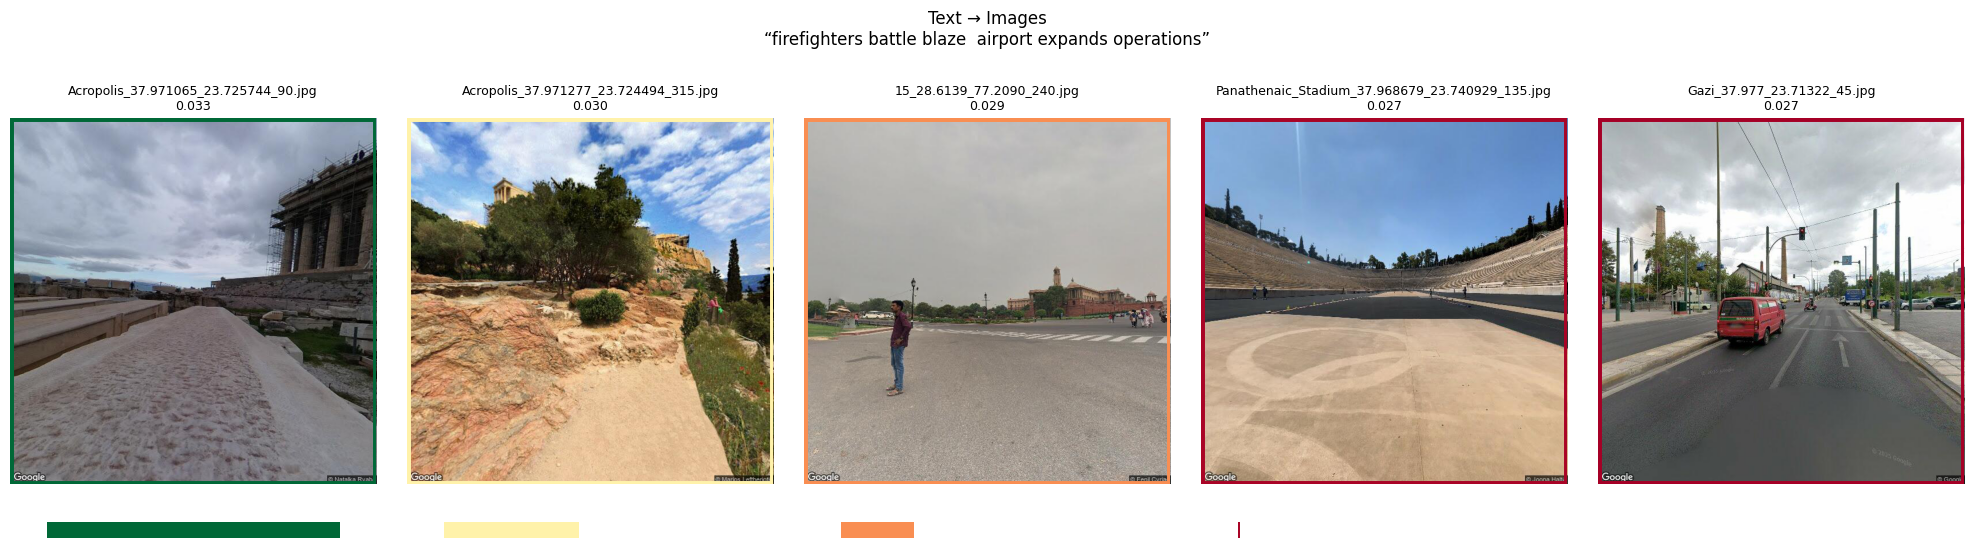

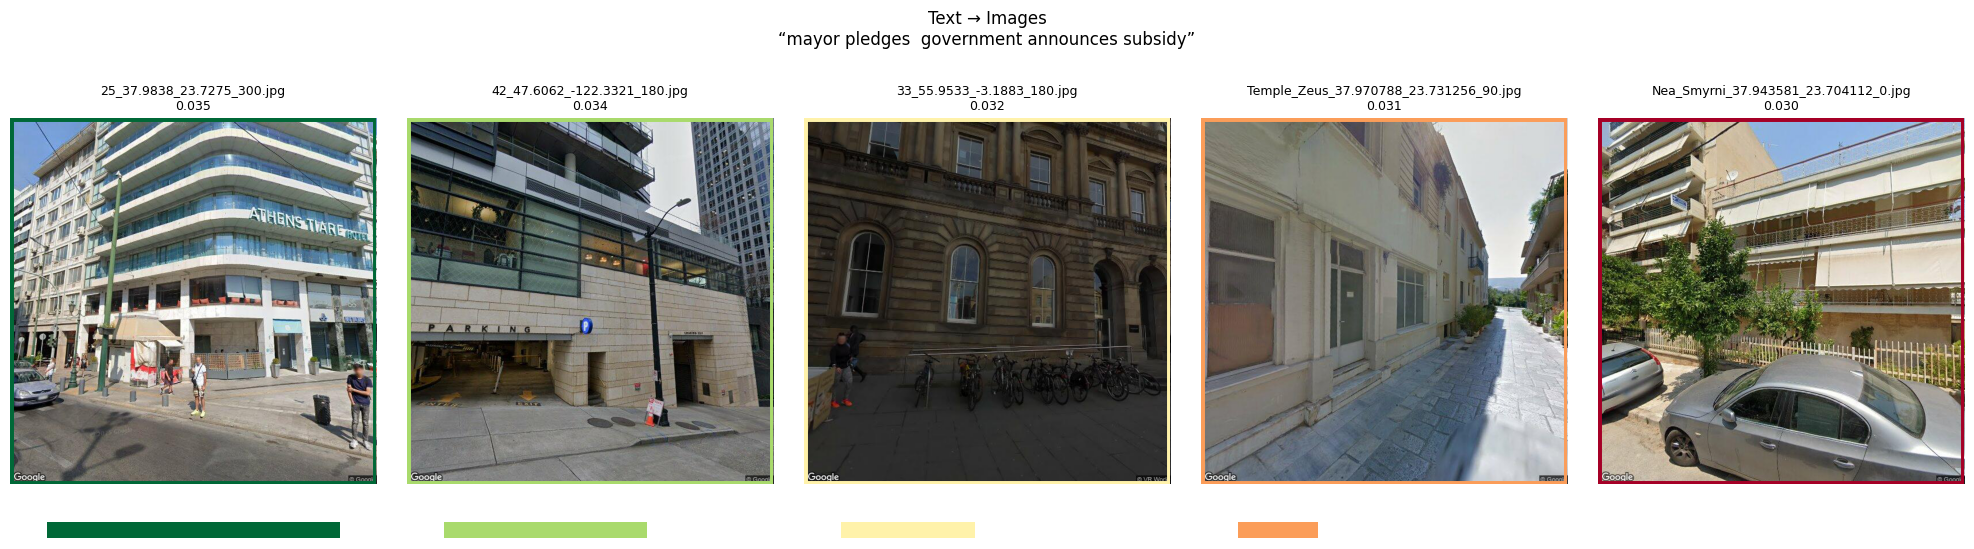

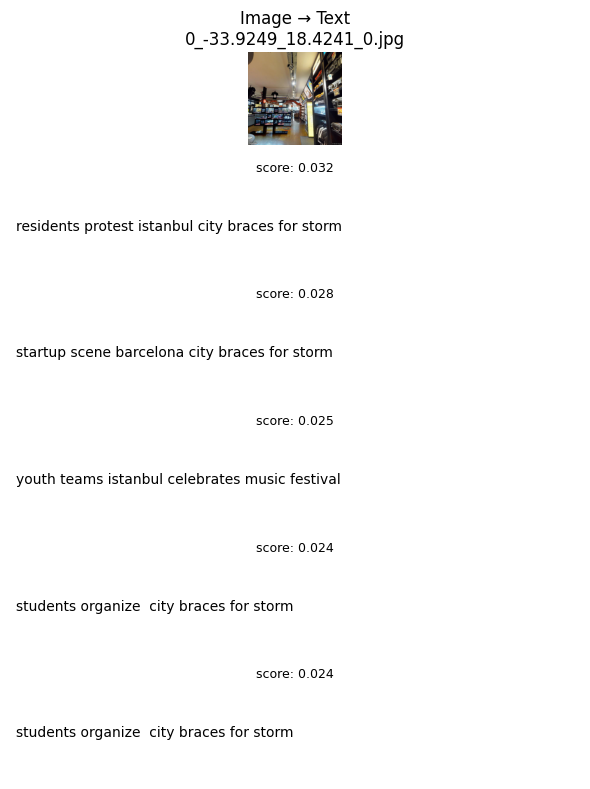

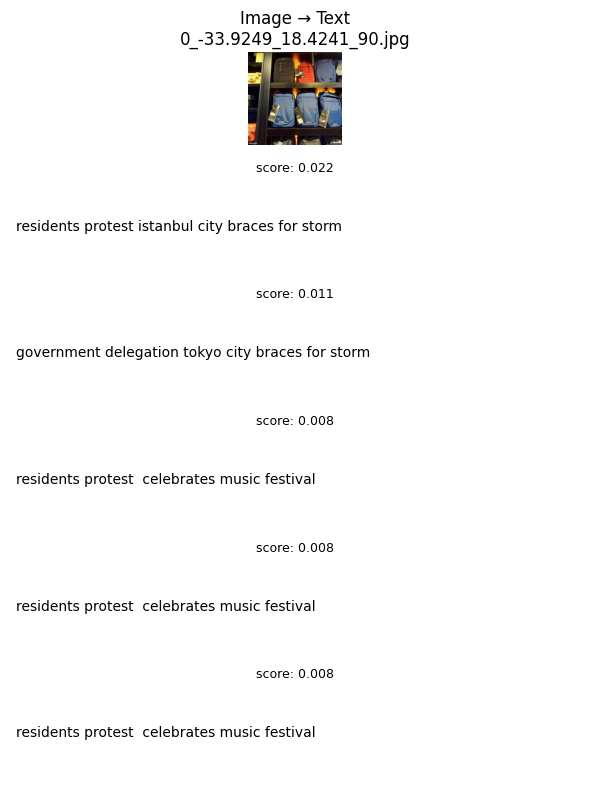

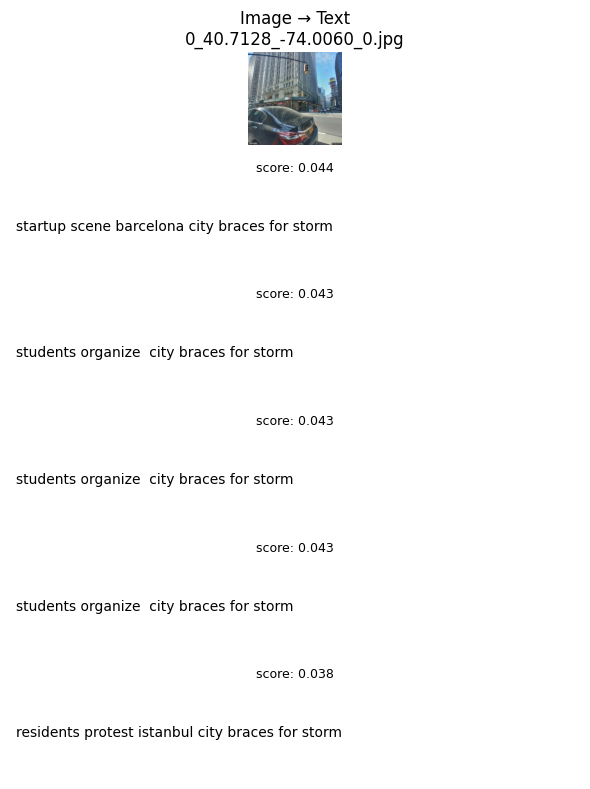

In [16]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image
from matplotlib import cm

# —— 0. Define paths and parameters —— #
TEXT2IMG = 'matches_text2img.json'
IMG2TEXT = 'matches_img2text.json'
IMG_DIR   = 'added image'  # adjust if needed
N_EXAMPLES = 3             # number of examples to visualize

# —— 1. Load the JSON mappings —— #
with open(TEXT2IMG, 'r', encoding='utf-8') as f:
    text2img = json.load(f)
with open(IMG2TEXT, 'r', encoding='utf-8') as f:
    img2text = json.load(f)

# —— 2. Pick examples —— #
text_keys = list(text2img.keys())[:N_EXAMPLES]
img_keys  = list(img2text.keys())[:N_EXAMPLES]

# —— 3. Set up colormap —— #
cmap = cm.get_cmap('RdYlGn')  # green=high score, red=low score

# —— 4. Visualize Text → Images with colored borders and score bars —— #
for text in text_keys:
    matches = text2img[text]
    scores = [s for _, s in matches]
    vmin, vmax = min(scores), max(scores)
    fig, axes = plt.subplots(1, len(matches), figsize=(4*len(matches), 5))
    fig.suptitle(f"Text → Images\n“{text}”", fontsize=12)
    if len(matches) == 1:
        axes = [axes]
    for ax, (img_name, score) in zip(axes, matches):
        img_path = os.path.join(IMG_DIR, img_name)
        try:
            img = Image.open(img_path)
            ax.imshow(img)
        except FileNotFoundError:
            ax.text(0.5, 0.5, f"Missing:\n{img_name}", ha='center')
        ax.axis('off')
        # Normalize score for color mapping
        norm_score = (score - vmin) / (vmax - vmin) if vmax > vmin else 0.5
        color = cmap(norm_score)
        # Draw colored border
        rect = Rectangle((0, 0), 1, 1, transform=ax.transAxes,
                         fill=False, lw=5, edgecolor=color)
        ax.add_patch(rect)
        # Draw score bar underneath
        bar_ax = ax.inset_axes([0.1, -0.15, 0.8, 0.05])
        bar_ax.barh([0], [norm_score], color=color)
        bar_ax.set_xlim(0, 1)
        bar_ax.axis('off')
        ax.set_title(f"{img_name}\n{score:.3f}", fontsize=9)
    plt.tight_layout(rect=[0, 0, 1, 0.9])
    plt.show()

# —— 5. Visualize Image → Text with background shading —— #
for img_name in img_keys:
    matches = img2text[img_name]
    scores = [s for _, s in matches]
    vmin, vmax = min(scores), max(scores)
    fig = plt.figure(figsize=(6, 2 + 1.2 * len(matches)))
    # Show the image
    ax0 = fig.add_subplot(len(matches)+1, 1, 1)
    img_path = os.path.join(IMG_DIR, img_name)
    try:
        img = Image.open(img_path)
        ax0.imshow(img)
    except FileNotFoundError:
        ax0.text(0.5, 0.5, f"Missing:\n{img_name}", ha='center')
    ax0.axis('off')
    ax0.set_title(f"Image → Text\n{img_name}", fontsize=12)
    # Show matched texts with colored background
    for idx, (text, score) in enumerate(matches, start=2):
        ax = fig.add_subplot(len(matches)+1, 1, idx)
        norm_score = (score - vmin) / (vmax - vmin) if vmax > vmin else 0.5
        bg_color = cmap(norm_score, alpha=0.3)
        ax.set_facecolor(bg_color)
        ax.text(0.01, 0.5, text, wrap=True, fontsize=10, va='center')
        ax.set_title(f"score: {score:.3f}", fontsize=9)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


c:\Users\golds\miniconda3\envs\torch_pig\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\golds\miniconda3\envs\torch_pig\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 35797 (\N{CJK UNIFIED IDEOGRAPH-8BD5}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\golds\miniconda3\envs\torch_pig\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


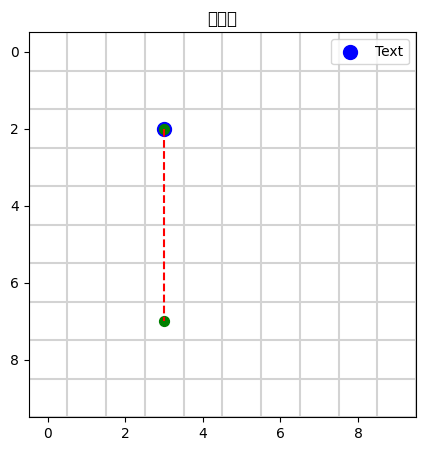

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

som_weights = np.random.randn(10,10,3)

text_vector  = np.array([0.1, 0.5, -0.2])
image_vectors = [
    np.array([0.2, 0.4, -0.1]),
    np.array([-0.3, 0.1, 0.8])
]

def find_bmu(weights, vec):
    gx, gy, dim = weights.shape
    flat = weights.reshape(-1, dim)
    idx = np.argmin(np.linalg.norm(flat - vec, axis=1))
    return divmod(idx, gy)

def plot_som_matches(weights, tvec, ivecs, title=None):
    gx, gy, _ = weights.shape
    text_bmu = find_bmu(weights, tvec)
    img_bmus = [find_bmu(weights, v) for v in ivecs]

    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_xlim(-0.5, gx-0.5); ax.set_ylim(gy-0.5, -0.5)

    for x in range(gx+1): ax.axvline(x-0.5, c='lightgray')
    for y in range(gy+1): ax.axhline(y-0.5, c='lightgray')

    tr, tc = text_bmu
    ax.scatter(tc, tr, s=100, c='blue', label='Text')
    for ir, ic in img_bmus:
        ax.scatter(ic, ir, s=50, c='green')
        ax.plot([tc, ic], [tr, ir], '--', c='red')
    if title: ax.set_title(title)
    ax.legend()
    plt.show()

plot_som_matches(som_weights, text_vector, image_vectors, title="SOM Matches")
